### Load Library

In [1]:
%matplotlib inline
import os
os.chdir("/Users/liyanran/Desktop/23Fall/STCS6701probML/probML6701/hw3")

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import seaborn as sns
import pyreadr
import pymc as pm


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [4]:
ts_wconf = pyreadr.read_r("./ts_wconf.RDS")
ts = ts_wconf[None]
print(ts.head())

   StateCounty_FIPS        Date  HImaxF_PopW    county     zone state  warn  \
0            1001.0  2006-04-01    81.951271   Autauga   AL-041    AL   0.0   
1            1001.0  2006-04-02    85.977650   Autauga   AL-041    AL   0.0   
2            1001.0  2006-04-03    82.727648   Autauga   AL-041    AL   0.0   
3            1001.0  2006-04-04    72.847272   Autauga   AL-041    AL   0.0   
4            1001.0  2006-04-05    76.618135   Autauga   AL-041    AL   0.0   

   adv  alert    year  ...  no_grad_mcare  median_household_income  \
0  0.0    0.0  2006.0  ...       0.281955             52060.333333   
1  0.0    0.0  2006.0  ...       0.281955             52060.333333   
2  0.0    0.0  2006.0  ...       0.281955             52060.333333   
3  0.0    0.0  2006.0  ...       0.281955             52060.333333   
4  0.0    0.0  2006.0  ...       0.281955             52060.333333   

   owner_occupied  median_age  age_pct_0_14  age_pct_15_44  age_pct_45_65  \
0        0.768343   36.3333

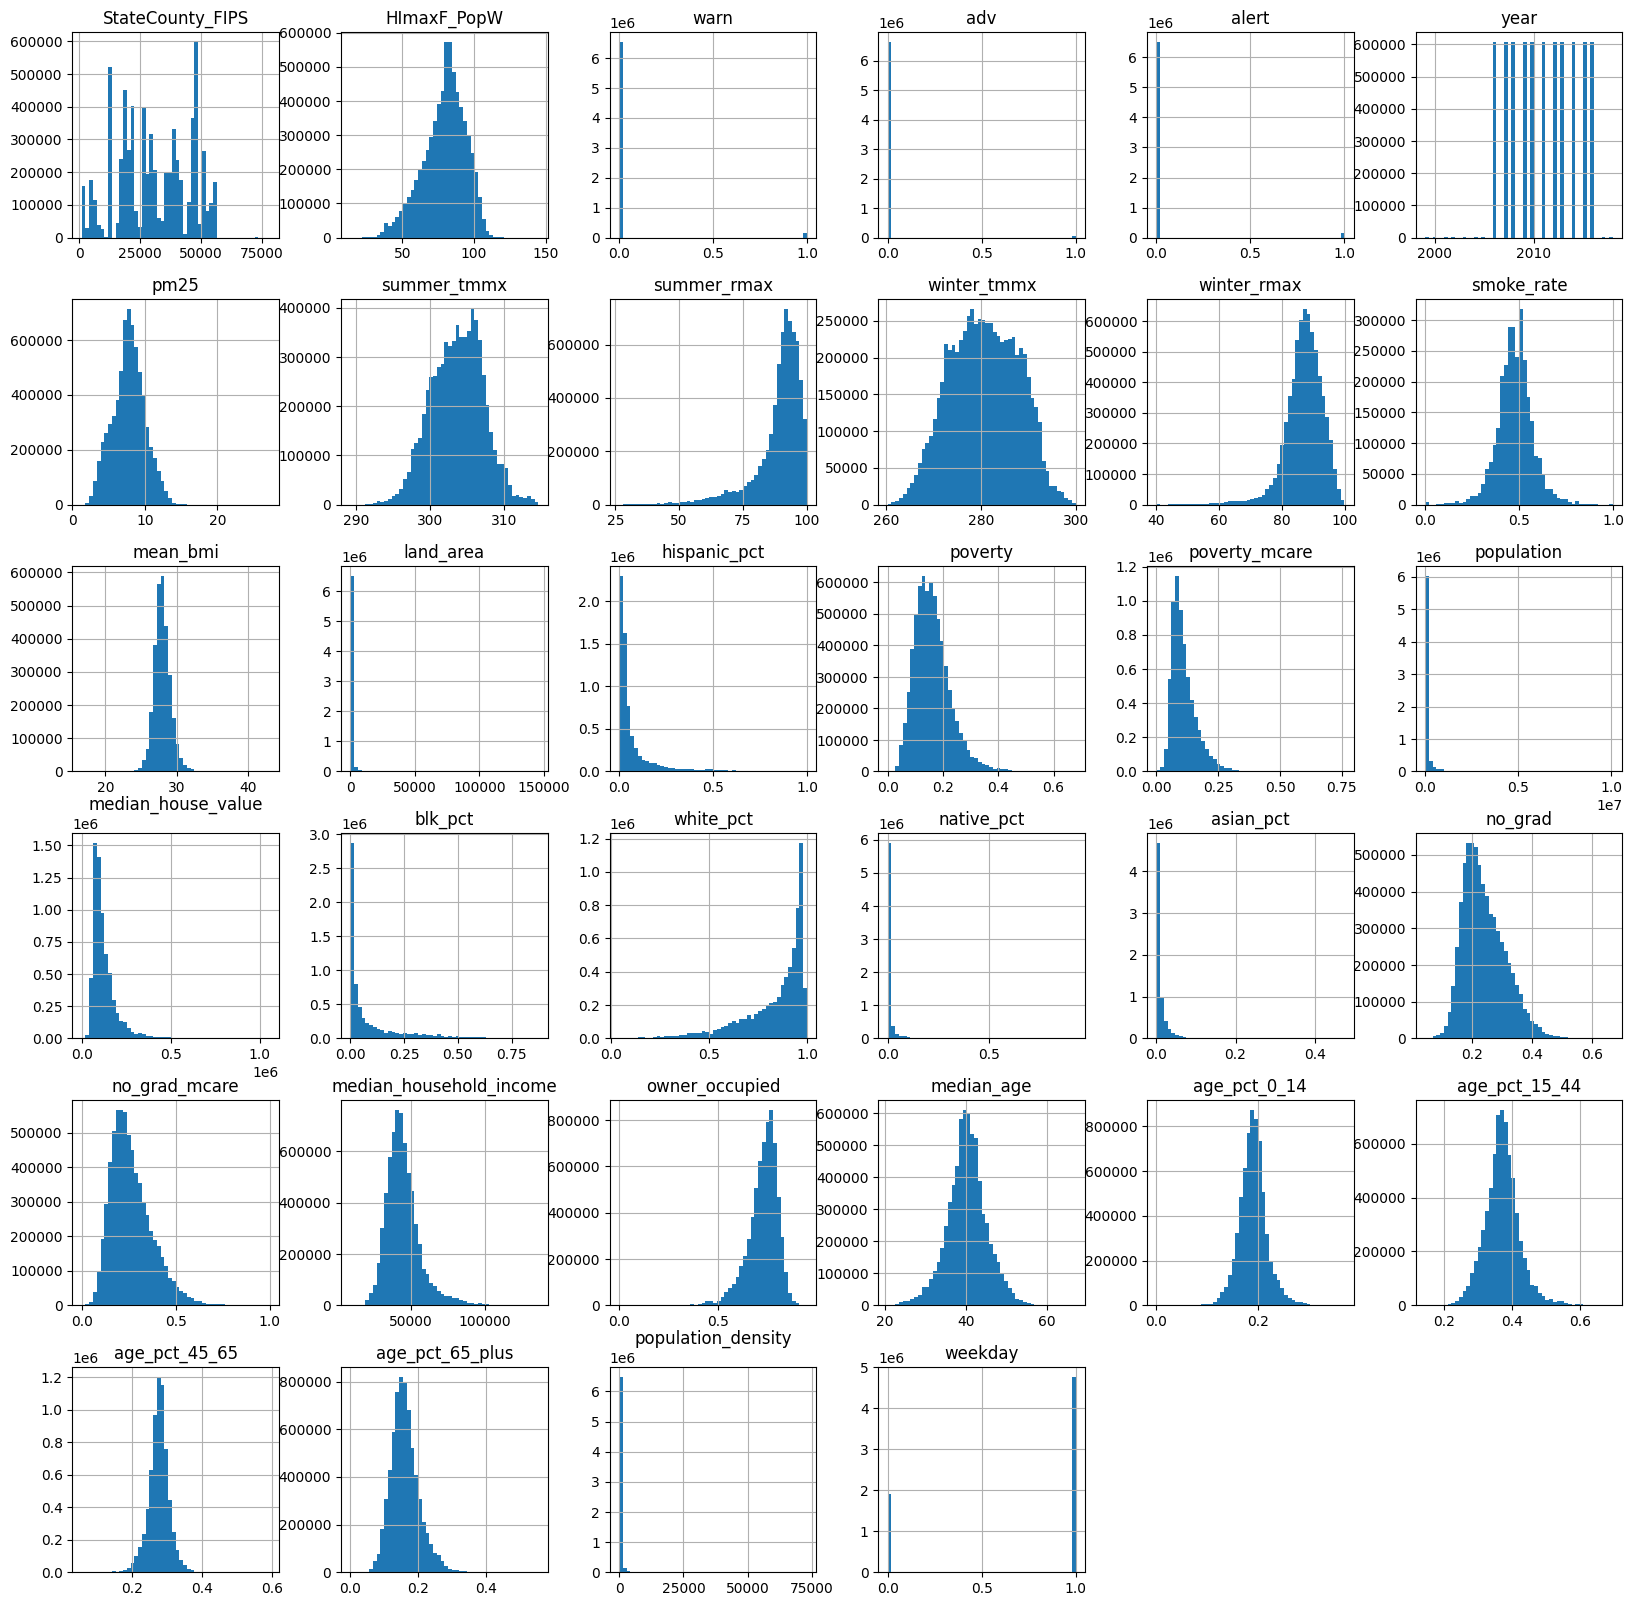

In [3]:
_ = ts.hist(bins=50, figsize=(20,20))

In [5]:
# select 2007
ts_2007 = ts[ts['year'] == 2007]

In [4]:
# print column names
print(ts_2007.columns)

Index(['StateCounty_FIPS', 'Date', 'HImaxF_PopW', 'county', 'zone', 'state',
       'warn', 'adv', 'alert', 'year', 'pm25', 'summer_tmmx', 'summer_rmax',
       'winter_tmmx', 'winter_rmax', 'smoke_rate', 'mean_bmi', 'NAME',
       'land_area', 'hispanic_pct', 'poverty', 'poverty_mcare', 'population',
       'median_house_value', 'blk_pct', 'white_pct', 'native_pct', 'asian_pct',
       'no_grad', 'no_grad_mcare', 'median_household_income', 'owner_occupied',
       'median_age', 'age_pct_0_14', 'age_pct_15_44', 'age_pct_45_65',
       'age_pct_65_plus', 'population_density', 'weekday'],
      dtype='object')


In [6]:
# select columns

ts = ts_2007[['StateCounty_FIPS', 'Date', "HImaxF_PopW", "county",'warn', 'adv', "alert", 'year', 'pm25', 'summer_tmmx', 'summer_rmax', 'winter_tmmx', 'winter_rmax', 'smoke_rate', 'mean_bmi', 'land_area', 'hispanic_pct', 'poverty', 'poverty_mcare', 'population',
       'median_house_value', 'blk_pct', 'white_pct', 'native_pct', 'asian_pct',
       'no_grad', 'no_grad_mcare', 'median_household_income', 'owner_occupied',
       'median_age','population_density', 'weekday']]

In [51]:
ts = ts.dropna()
county_idxs, counties = pd.factorize(ts.county)
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [7]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = "retina"

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In [8]:
ts = ts.dropna()

features = ["pm25", "smoke_rate", "population", "weekday"]

X = ts[features]
Y = ts["HImaxF_PopW"]

In [42]:
ts.shape

(442338, 32)

In [41]:
ts.head()

StateCounty_FIPS        Date  HImaxF_PopW    county  warn  adv  alert  \
214            1001.0  2007-04-01    75.806902   Autauga   0.0  0.0    0.0   
215            1001.0  2007-04-02    83.541869   Autauga   0.0  0.0    0.0   
216            1001.0  2007-04-03    84.437570   Autauga   0.0  0.0    0.0   
217            1001.0  2007-04-04    74.225980   Autauga   0.0  0.0    0.0   
218            1001.0  2007-04-05    57.881057   Autauga   0.0  0.0    0.0   

       year       pm25  summer_tmmx  ...  white_pct  native_pct  asian_pct  \
214  2007.0  12.803966   307.346143  ...   0.789279    0.005435   0.008215   
215  2007.0  12.803966   307.346143  ...   0.789279    0.005435   0.008215   
216  2007.0  12.803966   307.346143  ...   0.789279    0.005435   0.008215   
217  2007.0  12.803966   307.346143  ...   0.789279    0.005435   0.008215   
218  2007.0  12.803966   307.346143  ...   0.789279    0.005435   0.008215   

      no_grad  no_grad_mcare  median_household_income  owner_occupied  \
214  0.264989        0.27476                  52323.0        0.769648   
215  0.264989        0.27476                  52323.0        0.769648   
216  0.264989        0.27476                  52323.0        0.769648   
217  0.264989        0.27476                  52323.0        0.769648   
218  0.264989        0.27476                  52323.0        0.769648   

     median_age  population_density  weekday  
214   36.342857           86.857194      0.0  
215   36.342857           86.857194      1.0  
216   36.342857           86.857194      1.0  
217   36.342857           86.857194      1.0  
218   36.342857           86.857194      1.0  

[5 rows x 32 columns]

In [9]:

with pm.Model() as model_bikes:
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y), m=50)
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y)
    idata_bikes = pm.sample(compute_convergence_checks=False, random_seed=123)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16093 seconds.


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


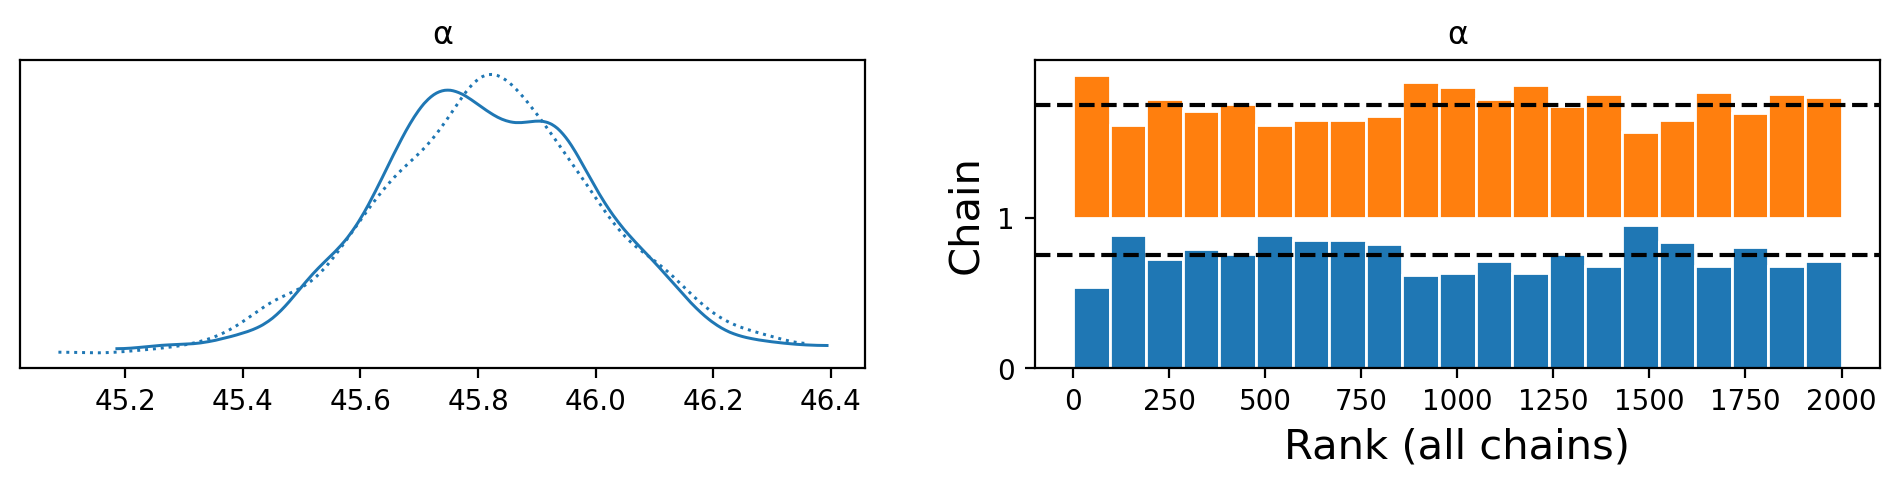

In [10]:
az.plot_trace(idata_bikes, var_names=["α"], kind="rank_bars");

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


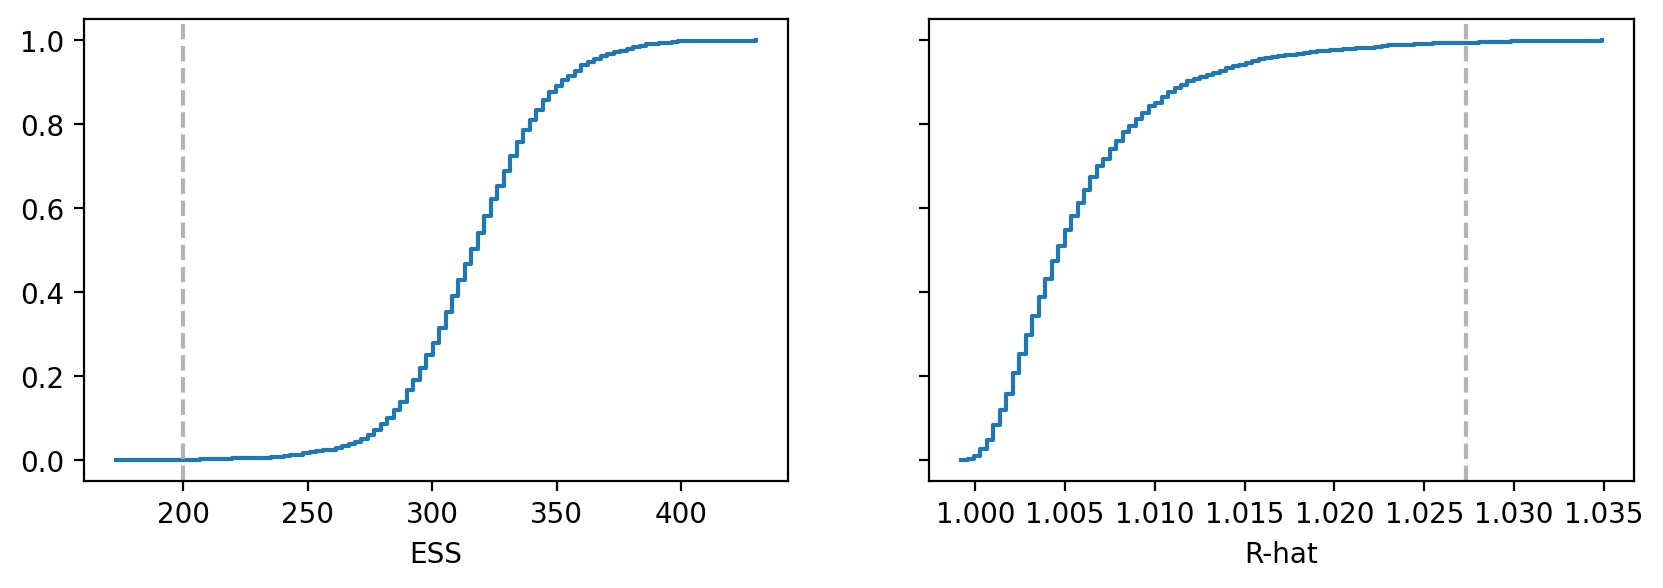

In [11]:
pmb.plot_convergence(idata_bikes, var_name="μ");

In [ ]:
az.plot_trace(idata_bikes, var_names=["\u03BC"]);

/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/pymc_bart/utils.py:786: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  chains_hdi = az.hdi((var_imp_chains.T / var_imp_chains.sum(axis=1)).T)[indices]


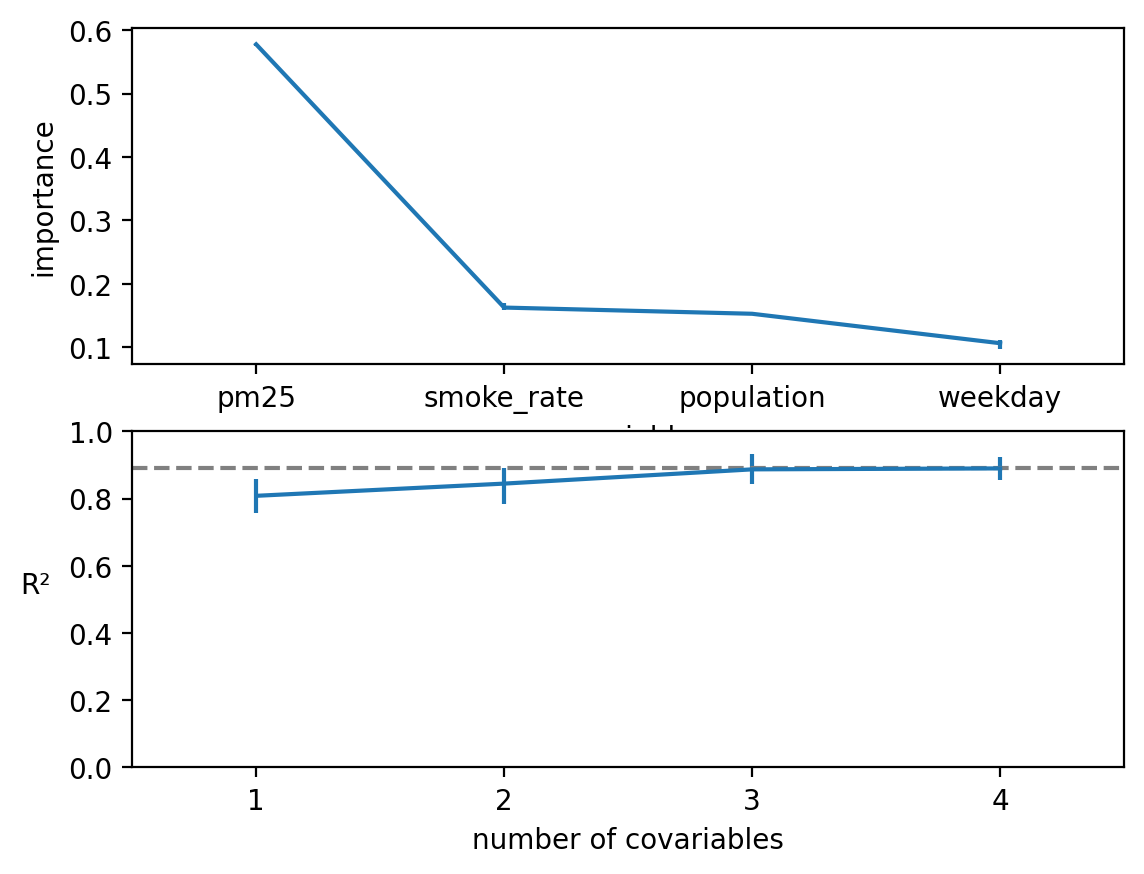

In [25]:
pmb.plot_variable_importance(idata_bikes, μ, X, samples=100);

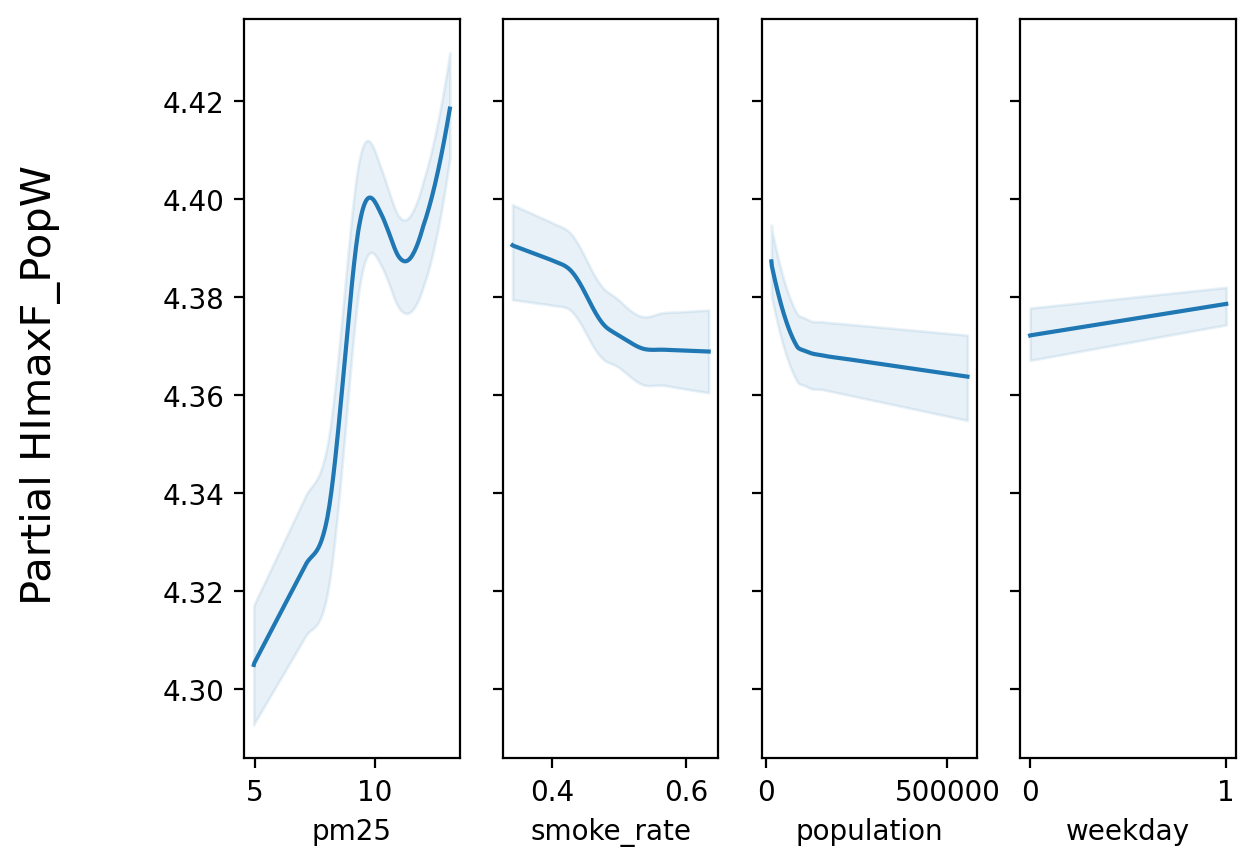

In [37]:
pmb.plot_pdp(μ, X=X, Y=Y, grid=(1,4));



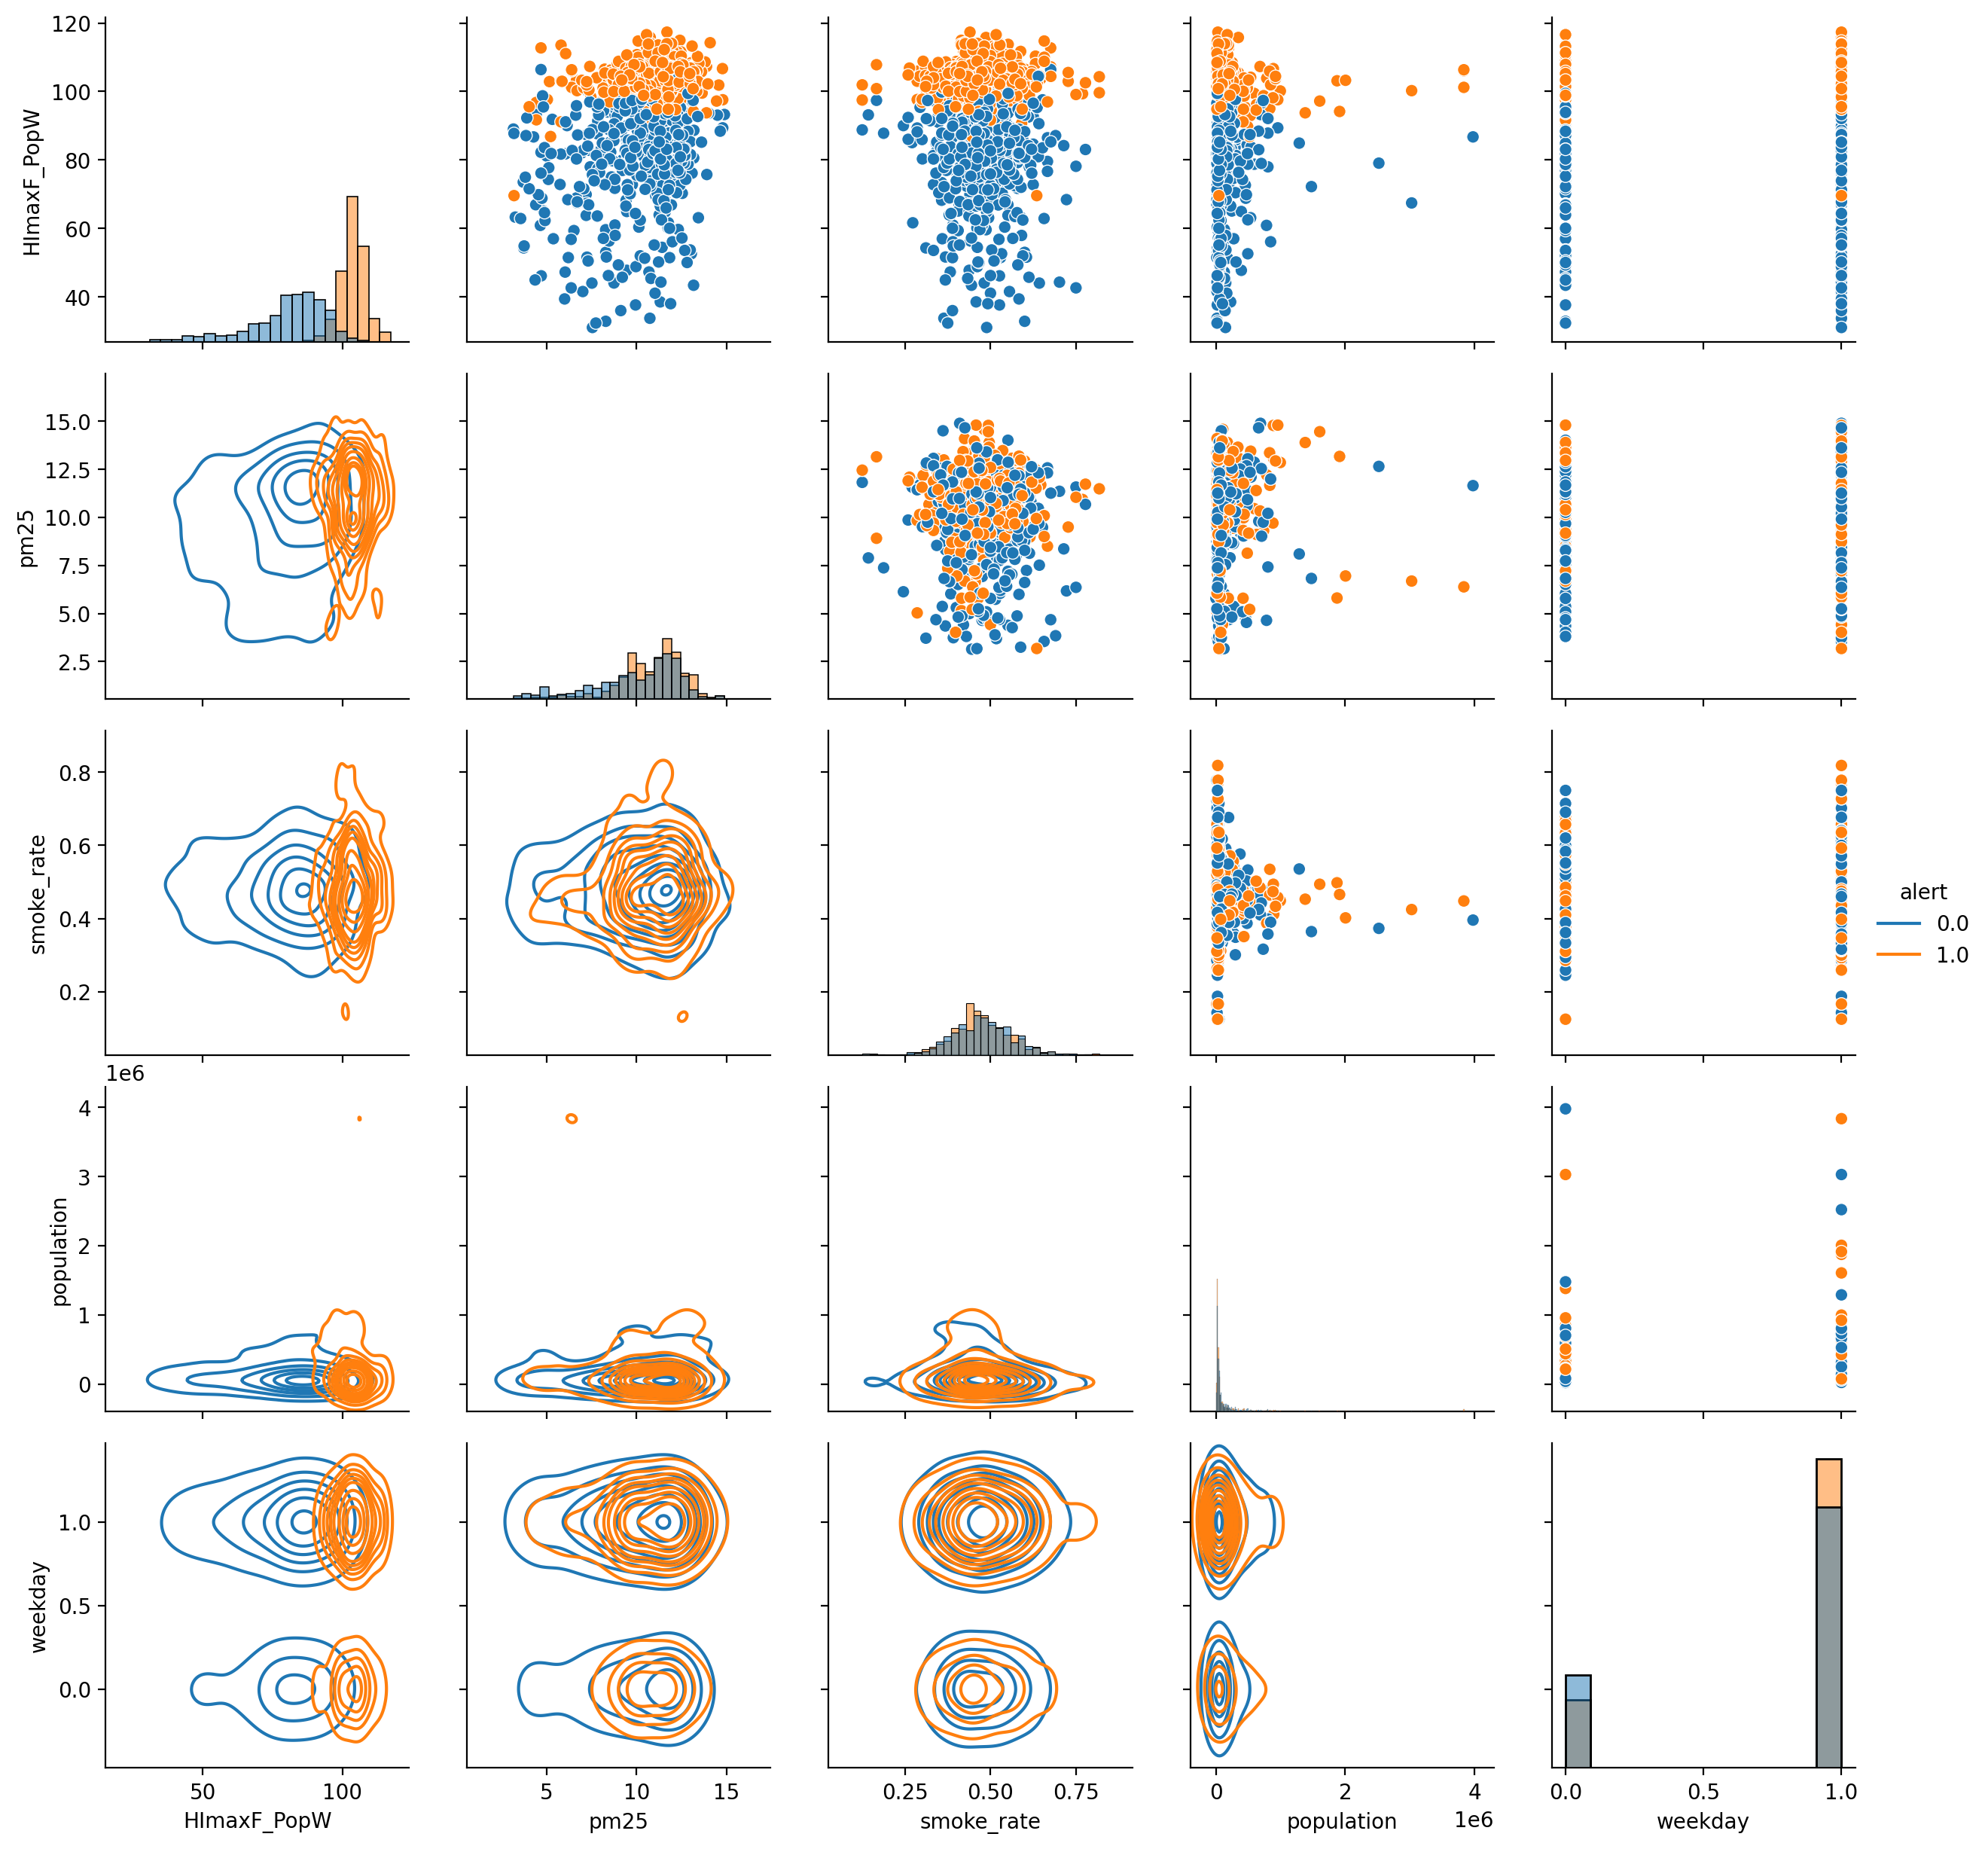

In [39]:
np.random.seed(42)
t = ts[["alert","HImaxF_PopW", 'pm25', 'smoke_rate', "population", "weekday"]].copy()

t.replace({r"\N": np.nan}, inplace=True)
t.dropna(subset=["pm25"], inplace=True)
t = t.astype(float)

n = len(t[t["alert"]==1])
t = pd.concat([t[t["alert"]==1], t[t["alert"]==0].sample(n)], axis=0).sample(1000)
g = sns.PairGrid(t, hue="alert")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

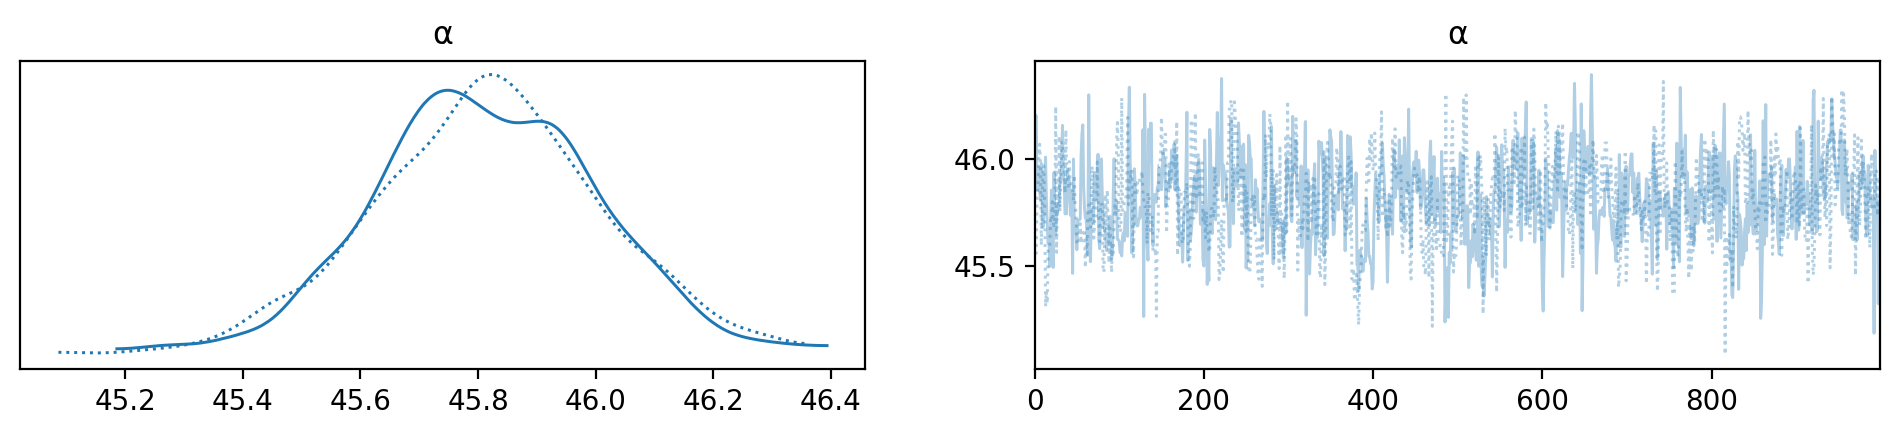

In [45]:
az.plot_trace(idata_bikes, var_names=["α"], kind='trace');

In [ ]:
az.plot_trace(idata_bikes, var_names=["μ"], kind='trace');

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=325)

In [50]:
with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    Y = Y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(μ), alpha=α, observed=Y, shape=μ.shape)
    idata_oos_regression = pm.sample(random_seed=325)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=325
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/liyanran/opt/anaconda3/envs/HeatAlert/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16830 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


In [55]:
with model_oos_regression:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=325
    )

Sampling: [y, μ]
